<a href="https://colab.research.google.com/github/veronicaramirezl/pytorch-deep-cnn/blob/main/neural_network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import sklearn
from sklearn.datasets import make_circles

#Make 1000 samples
samples = 1000

#Create circles
X, y = make_circles(n_samples=samples, noise=0.03, random_state=42)

print(X[:5])
print(y[:5])

[[ 0.75424625  0.23148074]
 [-0.75615888  0.15325888]
 [-0.81539193  0.17328203]
 [-0.39373073  0.69288277]
 [ 0.44220765 -0.89672343]]
[1 1 1 1 0]


In [2]:
# make df

import pandas as pd

circles = pd.DataFrame({'x1': X[:, 0],
                        'x2': X[:, 1],
                        'label': y})
circles.head()

,x1,x2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0


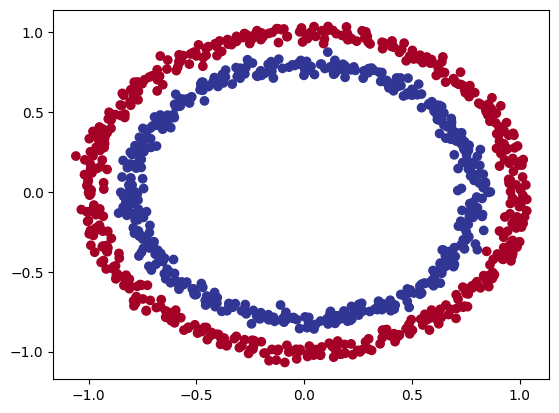

In [3]:
# visualize
import matplotlib.pyplot as plt

plt.scatter(x=X[:, 0],
            y=X[:, 1],
            c=y,
            cmap=plt.cm.RdYlBu)

In [4]:
# check input and output shapes
X.shape , y.shape


((1000, 2), (1000,))

In [5]:
# Turn data into tensors and divide
import torch

X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)
X[:5], y[:5]

(tensor([[ 0.7542,  0.2315],
         [-0.7562,  0.1533],
         [-0.8154,  0.1733],
         [-0.3937,  0.6929],
         [ 0.4422, -0.8967]]),
 tensor([1., 1., 1., 1., 0.]))

In [6]:
#SPLIT
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
len(X_train), len(X_test), len(y_train), len(y_test)

(800, 200, 800, 200)

## Building a model

1. set up device agnostic code on an accelerator
2. construct a model by subclassing a nn.Module
3. Define a loss function and optimizer
4. Create a training and test loop

In [7]:
import torch
from torch import nn

In [8]:
# lets build a model# Device agnostic code

device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

1. construct the module

a. Subclass nn.module
b. Create 2 nn.linear() kayers  (lyers that can handle the shape of our data )
c. defines a forward method (outlines the forward pass )
d. Instantiate an instance of our model class and send it to target device


In [9]:
# Subclass the module

class Circle_ModelV0(nn.Module):
    def __init__(self):
        super().__init__()
        #2. Create 2 nn.linear layers
        self.layer_1 = nn.Linear(in_features=2, out_features=5) #multiples of 8 for the out. It must be the same # for in
        self.layer_2 = nn.Linear(in_features=5, out_features=1) # out must be same shape as y

    #define forward method
    def forward(self, x):
        return self.layer_2(self.layer_1(x)) # put layer 1 into layer 2

# instantiate an instance of our model

model = Circle_ModelV0().to(device)
model

Circle_ModelV0(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
)

In [10]:
# Replicate CircleModelV0 with nn.Sequential
model_0 = nn.Sequential(
    nn.Linear(in_features=2, out_features=5),
    nn.Linear(in_features=5, out_features=1)
).to(device)

model_0

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)

In [11]:
# MAKE PREDICIONS

with torch.inference_mode():
  untrained_preds = model_0(X_test.to(device))

print( f'lenght of predictions: {len(untrained_preds)}')

print(f' shape: {untrained_preds.shape}')

print(f'len of test samples {len(X_test)}')

print( X_test.shape)

print(torch.round(untrained_preds[:10]))

print(y_test[:10])


lenght of predictions: 200
 shape: torch.Size([200, 1])
len of test samples 200
torch.Size([200, 2])
tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.]], device='cuda:0')
tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.])


In [12]:
# Pick a loss function and optimizer
'''
this is problem specific, for a loss:

Regression: nn.L1Loss or nn.MSELoss (MAE or MSE)
classification: nn.BCELoss or nn.BCEWithLogitsLoss (binary cross entropy or categorical cross entropy)

for optimizers:
    torch.optim.Adam
    torch.optim.SGD
'''

loss_fn = nn.BCEWithLogitsLoss() # binary cross entropy
optimizer = torch.optim.SGD(params=model_0.parameters(),
                            lr=0.1)



In [13]:
# calculate accuracy - out of 100 samples, what % does our mofel gt right

def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc


In [14]:
# oing from raw logits to prediction probabilities to predictions labels

# LOGITS ARE OUTPUTS!!!!! Turn them into prediction probabilities by passing them to some activation function (sigmoid for binary classification and softmax for multiclass )

# Then we can convert them to labels by either rounding them or taking th argmax()




In [15]:
# Train the model!!

'''
epochs in a range
run the model
do the forward pass
calculate the loss
optimizer zero grad
loss backward
optimizer step (gradient descent)
'''

torch.manual_seed(42)
epochs = 100

X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
    model_0.train()
    #forward pass

    y_logits = model_0(X_train).squeeze()
    activation= torch.sigmoid(y_logits) #predictin probabilities
    y_trained_labels = torch.round(activation)


    #Calculate the loss

    loss = loss_fn(y_logits,
                   y_train)
    accuracy = accuracy_fn(y_true= y_train,
                           y_pred= y_trained_labels)

    #optimizer zero grad
    optimizer.zero_grad()

    #loss backward
    loss.backward()

    #optimizer step
    optimizer.step()

    #Testing
    model_0.eval()
    with torch.inference_mode():
      #Do the forward pass
        test_logits = model_0(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))

        #calculate the loss

        test_loss= loss_fn(test_logits,
                           y_test)
        test_acc = accuracy_fn(y_true= y_test,
                               y_pred= test_pred)
  # pRINT OUT
    if epoch % 10 == 0:
      print(f"Epoch: {epoch} | Loss: {loss:.10f} | Acc: {accuracy:.2f}% | Test Loss: {test_loss:.5f} | Test Acc: {test_acc:.2f}%")




Epoch: 0 | Loss: 0.7035793662 | Acc: 50.00% | Test Loss: 0.70061 | Test Acc: 50.00%
Epoch: 10 | Loss: 0.6982471347 | Acc: 50.00% | Test Loss: 0.69581 | Test Acc: 50.00%
Epoch: 20 | Loss: 0.6958850026 | Acc: 58.13% | Test Loss: 0.69373 | Test Acc: 59.50%
Epoch: 30 | Loss: 0.6948100924 | Acc: 52.75% | Test Loss: 0.69283 | Test Acc: 56.50%
Epoch: 40 | Loss: 0.6943030953 | Acc: 52.00% | Test Loss: 0.69245 | Test Acc: 50.00%
Epoch: 50 | Loss: 0.6940501332 | Acc: 51.50% | Test Loss: 0.69229 | Test Acc: 49.00%
Epoch: 60 | Loss: 0.6939122677 | Acc: 50.62% | Test Loss: 0.69224 | Test Acc: 50.00%
Epoch: 70 | Loss: 0.6938276291 | Acc: 50.75% | Test Loss: 0.69223 | Test Acc: 50.50%
Epoch: 80 | Loss: 0.6937686205 | Acc: 50.00% | Test Loss: 0.69224 | Test Acc: 51.00%
Epoch: 90 | Loss: 0.6937223077 | Acc: 49.38% | Test Loss: 0.69226 | Test Acc: 51.50%


In [16]:
## The model is not doing anything lets visualize

#Lets use plot_decision_boundaries

In [17]:
import requests
from pathlib import Path

if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Downloading helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open ("helper_functions.py", "wb") as f:
    f.write(request.content)

from helper_functions import plot_decision_boundary, plot_predictions

helper_functions.py already exists, skipping download


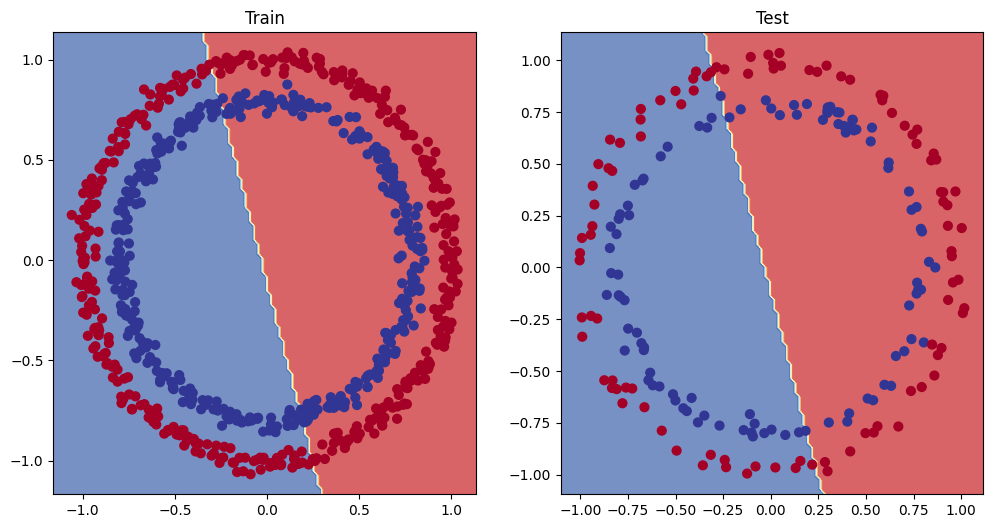

In [18]:
# plot decision boundary
plt.figure (figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_0, X_test, y_test)

In [19]:
# Improve the model
'''

Add more layeers - more chances to earn patterns
Add more hidden units
fit for longer
change the activation function (sigmoid)
change the learning rate ()
change the loss function
'''
#

'\n\nAdd more layeers - more chances to earn patterns\nAdd more hidden units \nfit for longer\nchange the activation function (sigmoid)\nchange the learning rate ()\nchange the loss function \n'

In [20]:


class Circle_ModelV1(nn.Module):
    def __init__(self):
        super().__init__()
        #2. Create 2 nn.linear layers

        #multiples of 8 for the out. It must be the same # for in
        self.layer_1 = nn.Linear(in_features=2, out_features=10)
        self.layer_2 = nn.Linear(in_features=10, out_features=10)
        self.layer_3 = nn.Linear(in_features=10, out_features=1)
  # out must be same shape as y

    #define forward method
    def forward(self, x):
        z = self.layer_1(x)
        z = self.layer_2(z)
        z = self.layer_3(z)
        return z

        # put layer 1 into layer 2

# instantiate an instance of our model

model1 = Circle_ModelV1().to(device)
model

Circle_ModelV0(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
)

In [21]:
#Create a loss function

loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(params=model1.parameters(),
                            lr=0.1)

In [22]:
# Train the model!!

'''
epochs in a range
run the model
do the forward pass
calculate the loss
optimizer zero grad
loss backward
optimizer step (gradient descent)
'''

torch.manual_seed(42)
epochs = 1000

X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)


for epoch in range(epochs):
    model1.train()
    #forward pass

    y_logits = model1(X_train).squeeze()
     #preditin probabilities
    y_pred= torch.round(torch.sigmoid(y_logits))


    #Calculate the loss

    loss = loss_fn(y_logits,
                   y_train)
    accuracy = accuracy_fn(y_true= y_train,
                           y_pred= y_pred)

    #optimizer zero grad
    optimizer.zero_grad()

    #loss backward
    loss.backward()

    #optimizer step
    optimizer.step()

    #Testing
    model1.eval()
    with torch.inference_mode():
      #Do the forward pass
        test_logits = model1(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))

        #calculate the loss

        test_loss= loss_fn(test_logits,
                           y_test)
        test_acc = accuracy_fn(y_true= y_test,
                               y_pred= test_pred)
  # pRINT OUT
    if epoch % 100 == 0:
      print(f"Epoch: {epoch} | Loss: {loss:.10f} | Acc: {accuracy:.2f}% | Test Loss: {test_loss:.5f} | Test Acc: {test_acc:.2f}%")




Epoch: 0 | Loss: 0.6939550638 | Acc: 50.88% | Test Loss: 0.69261 | Test Acc: 51.00%
Epoch: 100 | Loss: 0.6930478811 | Acc: 50.38% | Test Loss: 0.69379 | Test Acc: 48.00%
Epoch: 200 | Loss: 0.6929860711 | Acc: 51.12% | Test Loss: 0.69437 | Test Acc: 46.00%
Epoch: 300 | Loss: 0.6929804683 | Acc: 51.62% | Test Loss: 0.69458 | Test Acc: 45.00%
Epoch: 400 | Loss: 0.6929799318 | Acc: 51.12% | Test Loss: 0.69465 | Test Acc: 46.00%
Epoch: 500 | Loss: 0.6929798722 | Acc: 51.00% | Test Loss: 0.69467 | Test Acc: 46.00%
Epoch: 600 | Loss: 0.6929798722 | Acc: 51.00% | Test Loss: 0.69468 | Test Acc: 46.00%
Epoch: 700 | Loss: 0.6929798722 | Acc: 51.00% | Test Loss: 0.69468 | Test Acc: 46.00%
Epoch: 800 | Loss: 0.6929798722 | Acc: 51.00% | Test Loss: 0.69468 | Test Acc: 46.00%
Epoch: 900 | Loss: 0.6929798722 | Acc: 51.00% | Test Loss: 0.69468 | Test Acc: 46.00%


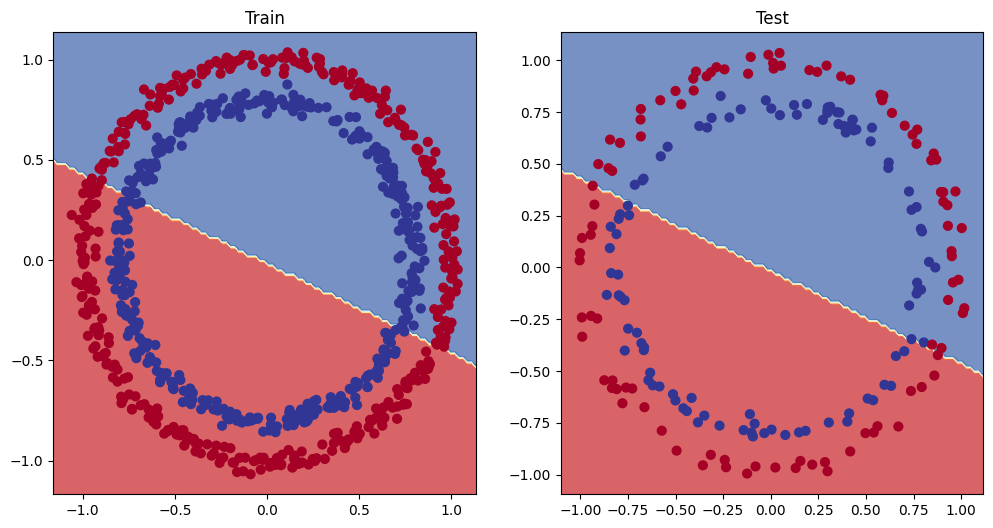

In [23]:
# plot decision boundary
plt.figure (figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model1, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model1, X_test, y_test)

In [24]:
# prove the method works in a lineardataset


'''
Troubleshoot in a smaller problem
'''


'\nTroubleshoot in a smaller problem\n'

In [25]:
# Crate data

weight = 0.7
bias = 0.3
start = -10
end = 10
step = 0.02

x_regression  = torch.arange(start, end, step).unsqueeze(dim=1)
y_regression = weight * x_regression + bias

In [26]:
train_split = int(0.8 * len(x_regression))
X_train_regression, y_train_regression = x_regression[:train_split], y_regression[:train_split]
X_test_regression, y_test_regression = x_regression[train_split:], y_regression[train_split:]

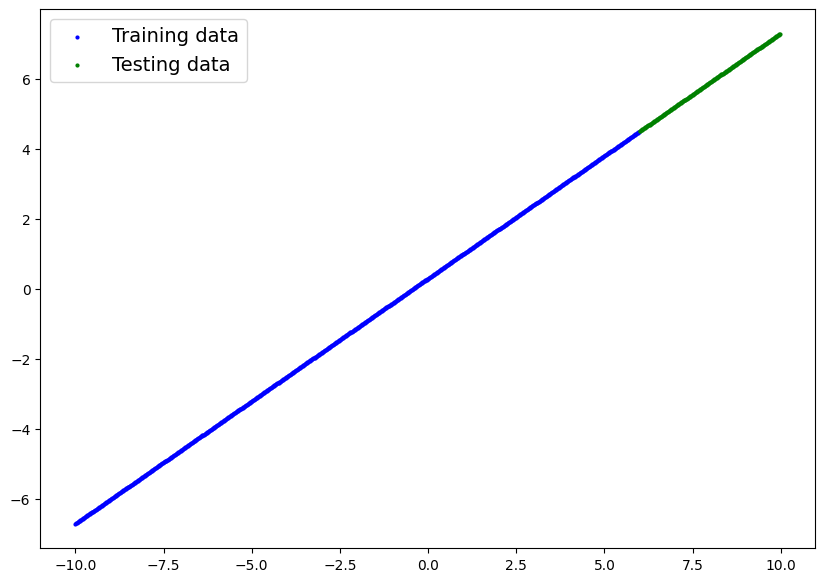

In [27]:
plot_predictions(train_data = X_train_regression,
                 train_labels = y_train_regression,
                 test_data = X_test_regression,
                 test_labels = y_test_regression)

In [28]:
# Create a nn for this


class LinRegModel(nn.Module):
    def __init__(self):
        super().__init__()

        self.linear_layer_1 = nn.Linear(in_features=1, out_features=10)
        self.linear_layer_2 = nn.Linear(in_features=10, out_features=10)
        self.linear_layer_3 = nn.Linear(in_features=10, out_features=1)

    def forward(self, x):
        return self.linear_layer_3(self.linear_layer_2(self.linear_layer_1(x)))

lin_model= LinRegModel()
lin_model

LinRegModel(
  (linear_layer_1): Linear(in_features=1, out_features=10, bias=True)
  (linear_layer_2): Linear(in_features=10, out_features=10, bias=True)
  (linear_layer_3): Linear(in_features=10, out_features=1, bias=True)
)

In [29]:
loss_fn_linear = nn.L1Loss()
optimizer = torch.optim.SGD(params=lin_model.parameters(),
                            lr=0.001)

In [30]:
#train and test the model

torch.manual_seed(42)
epochs = 1000

for epoch in range(epochs):

    lin_model.train()
    y_pred = lin_model(X_train_regression)
    loss = loss_fn_linear(y_pred, y_train_regression)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # test
    lin_model.eval()
    with torch.inference_mode():
      lin_model.eval()
      test_pred = lin_model(X_test_regression)
      test_loss = loss_fn_linear(test_pred,y_test_regression)
      test_acc = accuracy_fn(y_true= y_test_regression, y_pred= test_pred)


    #visualize
    if epoch % 100 == 0:
      print(f"Epoch: {epoch} | Loss: {loss:.10f} | Test Loss: {test_loss:.5f}")


Epoch: 0 | Loss: 1.5576876402 | Test Loss: 3.58827
Epoch: 100 | Loss: 0.3309494257 | Test Loss: 0.83819
Epoch: 200 | Loss: 0.1325601041 | Test Loss: 0.33208
Epoch: 300 | Loss: 0.0428945050 | Test Loss: 0.06212
Epoch: 400 | Loss: 0.0705691501 | Test Loss: 0.01476
Epoch: 500 | Loss: 0.0584756322 | Test Loss: 0.03894
Epoch: 600 | Loss: 0.0290518496 | Test Loss: 0.09201
Epoch: 700 | Loss: 0.0000063035 | Test Loss: 0.06628
Epoch: 800 | Loss: 0.0113068298 | Test Loss: 0.12290
Epoch: 900 | Loss: 0.0182040483 | Test Loss: 0.10968


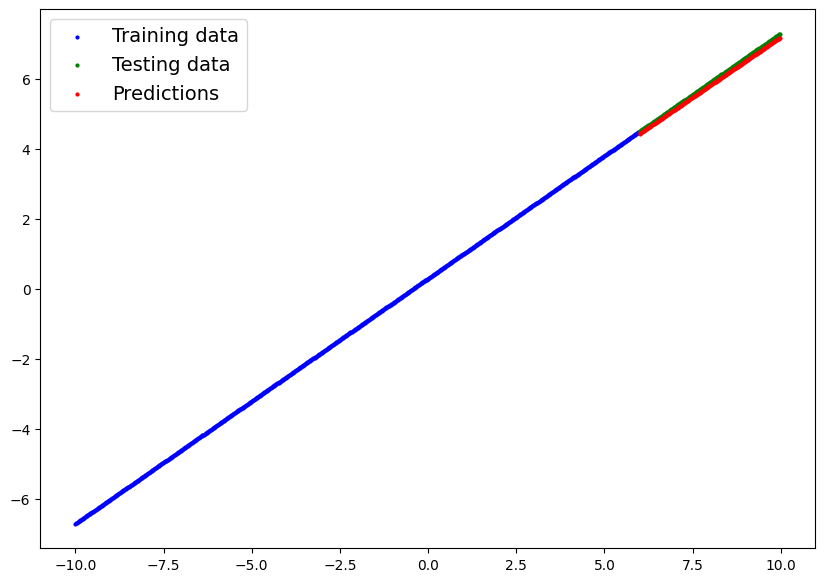

In [31]:
lin_model.eval()

with torch.inference_mode():
  y_preds = lin_model(X_test_regression)

plot_predictions(train_data = X_train_regression,
                 train_labels = y_train_regression,
                 test_data = X_test_regression,
                 test_labels = y_test_regression,
                 predictions = y_preds)

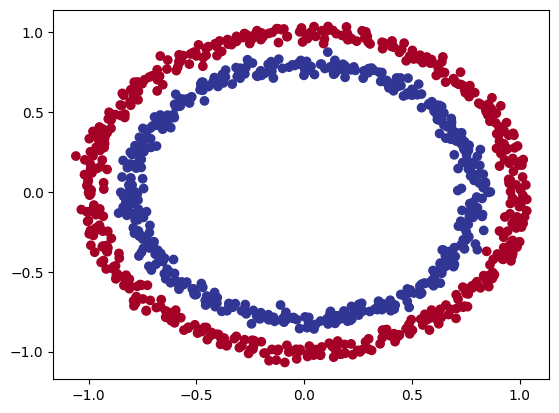

In [32]:
##non linearity: combining non linear and linear functions

n_samples = 1000

X, y = make_circles(n_samples, noise = 0.03, random_state = 42)

plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.RdYlBu)

In [33]:
# convet data to tensors nd then train  and test

X, y  = torch.from_numpy(X).type(torch.float), torch.from_numpy(y).type(torch.float)        #Turning data into tensors

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)   # Splitting

In [34]:
# Building a non-linear model

from torch import nn

class  NonLinearModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=10)
        self.layer_2 = nn.Linear(in_features = 10, out_features=10)
        self.layer_3 = nn.Linear(in_features=10, out_features=1)
        self.relu = nn.ReLU()                                                     # ReLU is a non lnear activation function

    def forward(self, x):
        return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))

NonLinearModel = NonLinearModel().to(device)

In [35]:
#Set up loss function and optimizer

loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(params=NonLinearModel.parameters(),
                            lr=0.1)

In [37]:
# Set up training dataset

torch.manual_seed(42)
epochs = 1000

X_train, y_train = X_train.to(device), y_train.to(device)                         #Setup device-agnostic code
X_test, y_test = X_test.to(device), y_test.to(device)


for epoch in range(epochs):

  NonLinearModel.train()                                                          # Train the model
  y_logits = NonLinearModel(X_train).squeeze()                                           # Forward pass
  y_pred = torch.round(torch.sigmoid(y_logits))
  loss = loss_fn(y_logits, y_train)                                     # Calculate the loss
  accuracy = accuracy_fn(y_true= y_train.cpu(), y_pred= y_pred.cpu())
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  # Evaluate the model

  NonLinearModel.eval()
  with torch.inference_mode():
    test_logits = NonLinearModel(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))
    test_loss = loss_fn(test_logits, y_test)
    test_acc = accuracy_fn(y_true = y_test.cpu(), y_pred = test_pred.cpu())

  # Visualize

  if epoch % 100 == 0:
    print(f"Epoch: {epoch} | Loss: {loss:.10f} | Acc: {accuracy:.2f}% | Test Loss: {test_loss:.5f} | Test Acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.5681842566 | Acc: 87.75% | Test Loss: 0.57378 | Test Acc: 86.50%
Epoch: 100 | Loss: 0.4815295339 | Acc: 93.50% | Test Loss: 0.49935 | Test Acc: 90.50%
Epoch: 200 | Loss: 0.3705617189 | Acc: 97.75% | Test Loss: 0.40595 | Test Acc: 92.00%
Epoch: 300 | Loss: 0.2545759082 | Acc: 99.00% | Test Loss: 0.30333 | Test Acc: 96.50%
Epoch: 400 | Loss: 0.1717981249 | Acc: 99.50% | Test Loss: 0.22108 | Test Acc: 97.50%
Epoch: 500 | Loss: 0.1218768656 | Acc: 99.62% | Test Loss: 0.16512 | Test Acc: 99.00%
Epoch: 600 | Loss: 0.0912287533 | Acc: 99.88% | Test Loss: 0.12741 | Test Acc: 99.50%
Epoch: 700 | Loss: 0.0710043982 | Acc: 99.88% | Test Loss: 0.10319 | Test Acc: 99.50%
Epoch: 800 | Loss: 0.0577335395 | Acc: 99.88% | Test Loss: 0.08672 | Test Acc: 99.50%
Epoch: 900 | Loss: 0.0485262722 | Acc: 99.88% | Test Loss: 0.07474 | Test Acc: 99.50%
